again, under the assumption that the road is flat and the camera perspective hasn't changed)


One thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead. If minpix is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window. This will repeat for however many windows are left in nwindows, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
from helper import points_extraction, corners_unwarp, abs_sobel_thresh, mag_thresh, dir_threshold, hls_select
from helper import hist, find_lane_pixels, fit_polynomial, fit_poly, search_around_poly, measure_curvature_pixels
from helper import measure_curvature_real, region_of_interest, draw_track, draw_track_with_lines
from line import Line

In [3]:
# make list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

(objpoints, imgpoints, retlist) = points_extraction(images, nx=9, ny=6)

Text(0.5,1,'Undistorted Image')

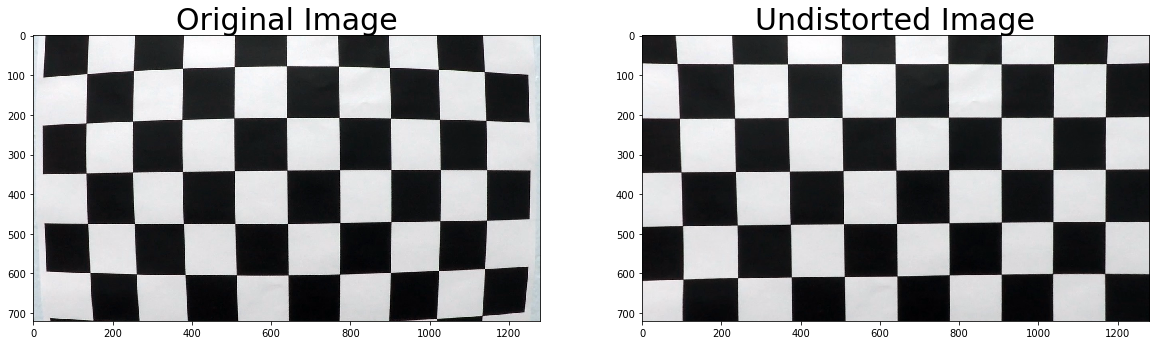

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

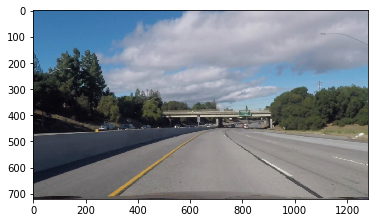

In [5]:
image = cv2.imread('test_images/challenge1.jpg')

dst = cv2.undistort(image, mtx, dist, None, mtx)

plt.imshow(dst)

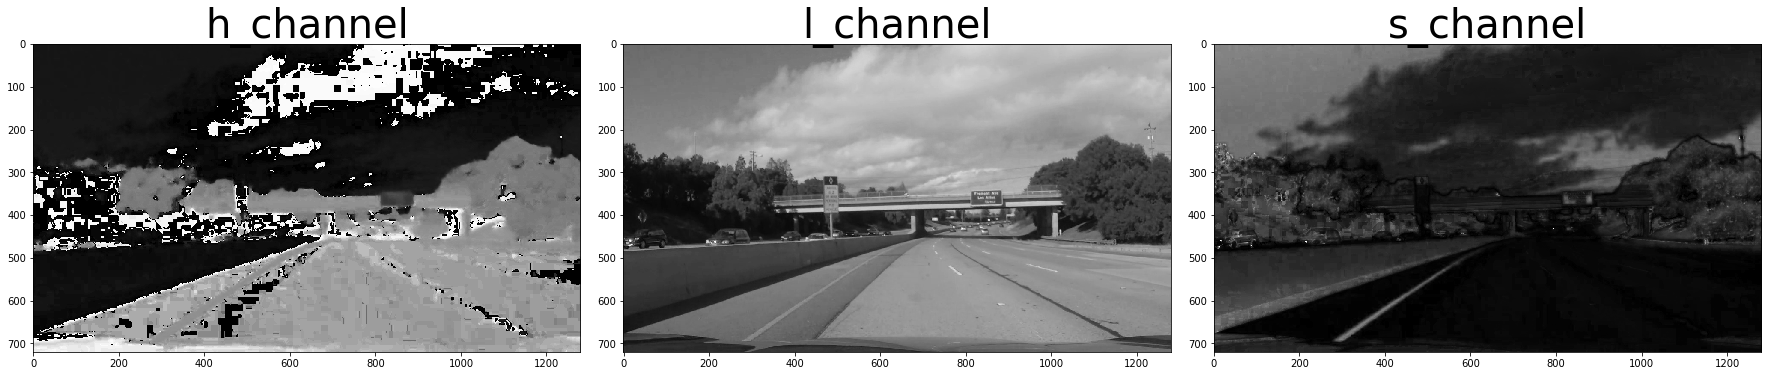

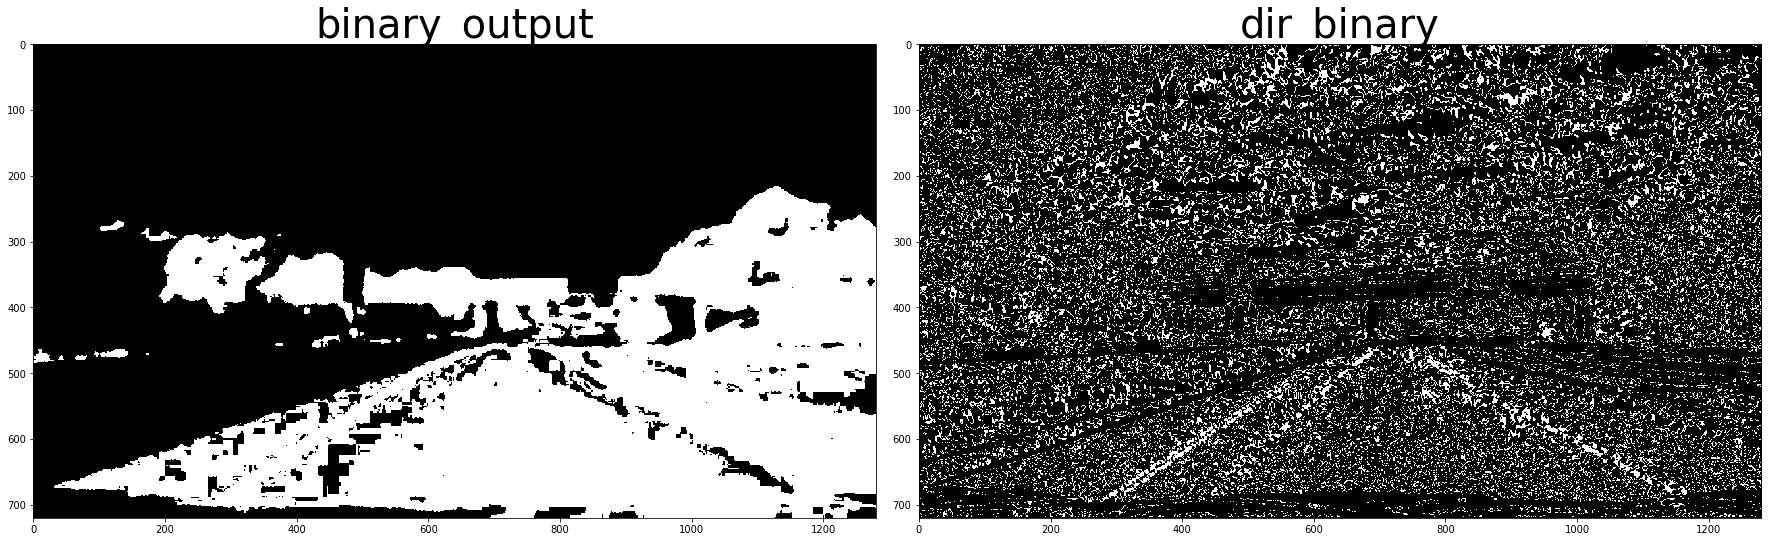

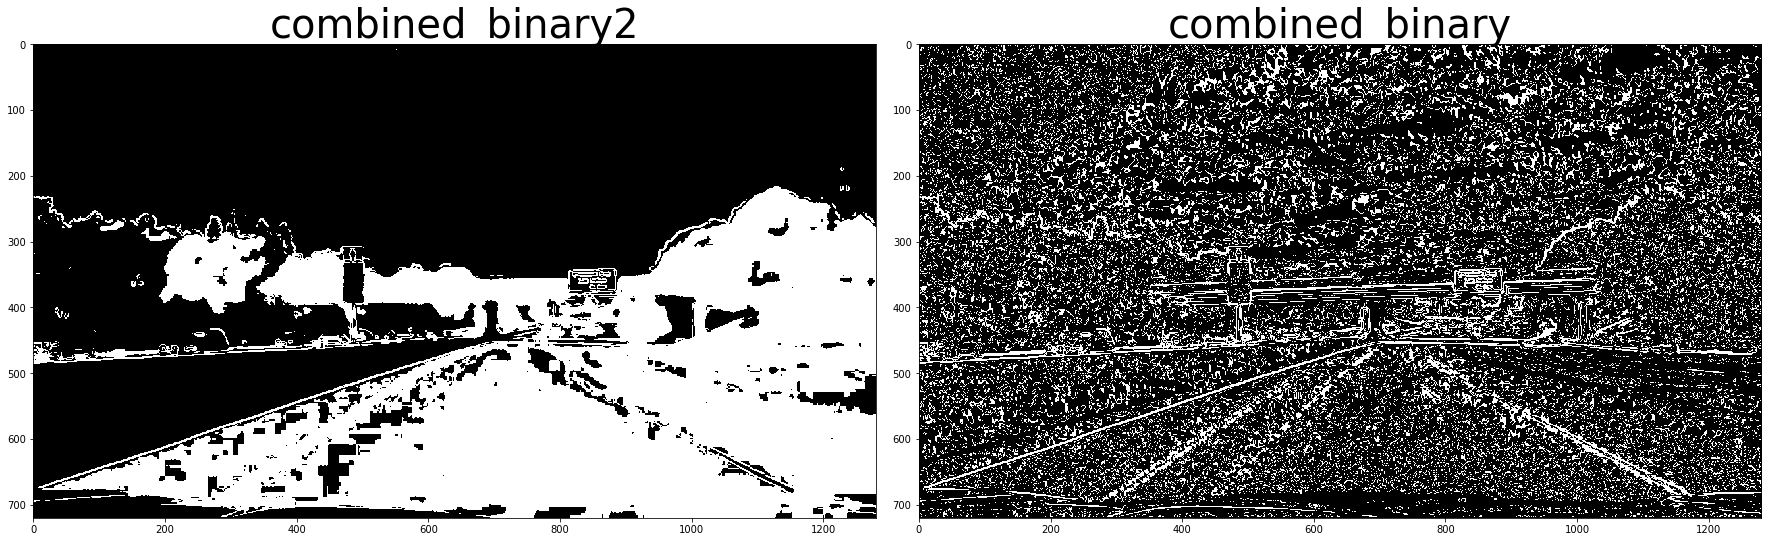

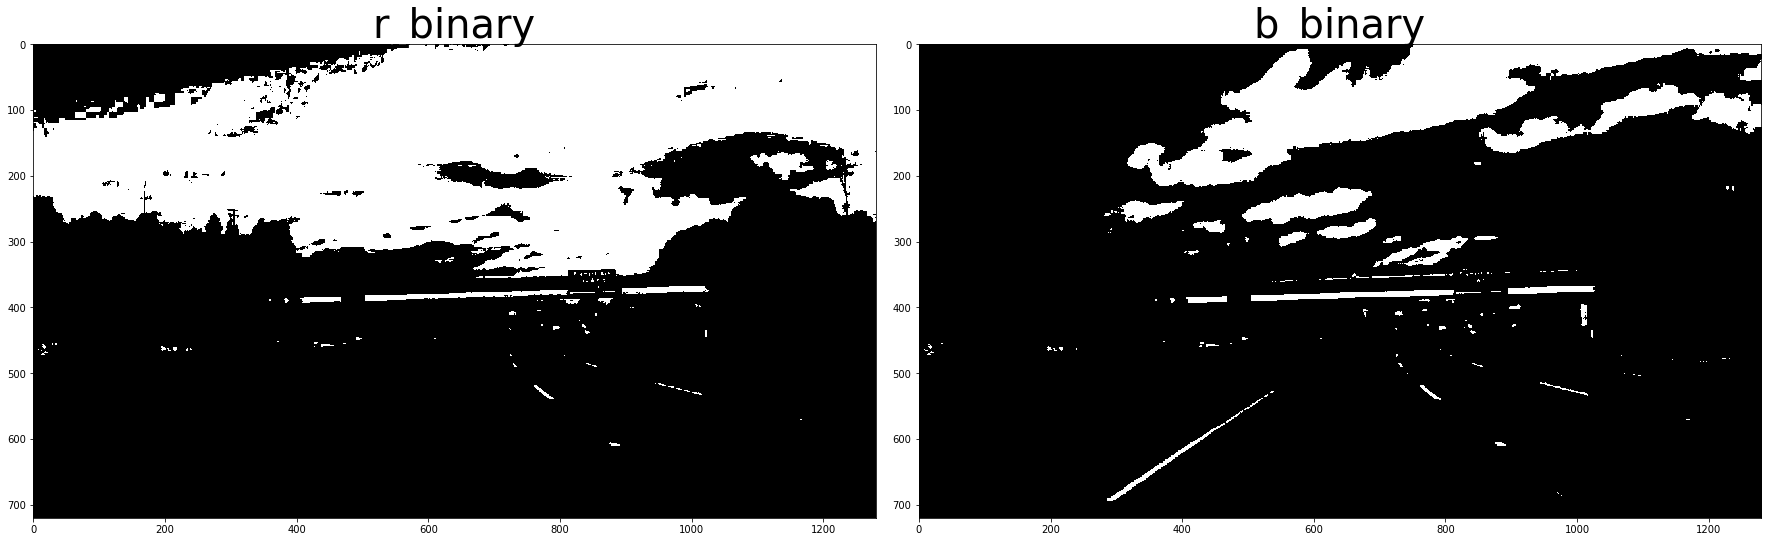

In [6]:
# image = cv2.imread('test_images/test5.jpg')
image = cv2.imread('test_images/challenge3.jpg')


# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

# dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

binary_output = np.zeros_like(h_channel)
binary_output[(h_channel > 70) & (h_channel <= 120)] = 1

mag_binary = mag_thresh(l_channel, sobel_kernel=9, mag_thresh=(55, 110))

dir_binary = dir_threshold(l_channel, sobel_kernel=13, thresh=(0.8, 1.1))

# Combine the two binary thresholds
combined_binary = np.zeros_like(dir_binary)
combined_binary[(mag_binary == 1) | (dir_binary == 1)] = 1

combined_binary2 = np.zeros_like(binary_output)
combined_binary2[(binary_output == 1) | (mag_binary == 1)] = 1

R = image[:,:,2]
G = image[:,:,1]
B = image[:,:,0]

r_thresh = (175, 255)
r_binary = np.zeros_like(R)
r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

g_thresh = (175, 255)
g_binary = np.zeros_like(G)
g_binary[(G > g_thresh[0]) & (G <= g_thresh[1])] = 1

b_thresh = (175, 255)
b_binary = np.zeros_like(B)
b_binary[(B > b_thresh[0]) & (B <= b_thresh[1])] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('h_channel', fontsize=40)

ax2.imshow(l_channel, cmap='gray')
ax2.set_title('l_channel', fontsize=40)

ax3.imshow(s_channel, cmap='gray')
ax3.set_title('s_channel', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_output, cmap='gray')
ax1.set_title('binary_output', fontsize=40)

ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('dir_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary2, cmap='gray')
ax1.set_title('combined_binary2', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('combined_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(r_binary, cmap='gray')
ax1.set_title('r_binary', fontsize=40)

ax2.imshow(b_binary, cmap='gray')
ax2.set_title('b_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

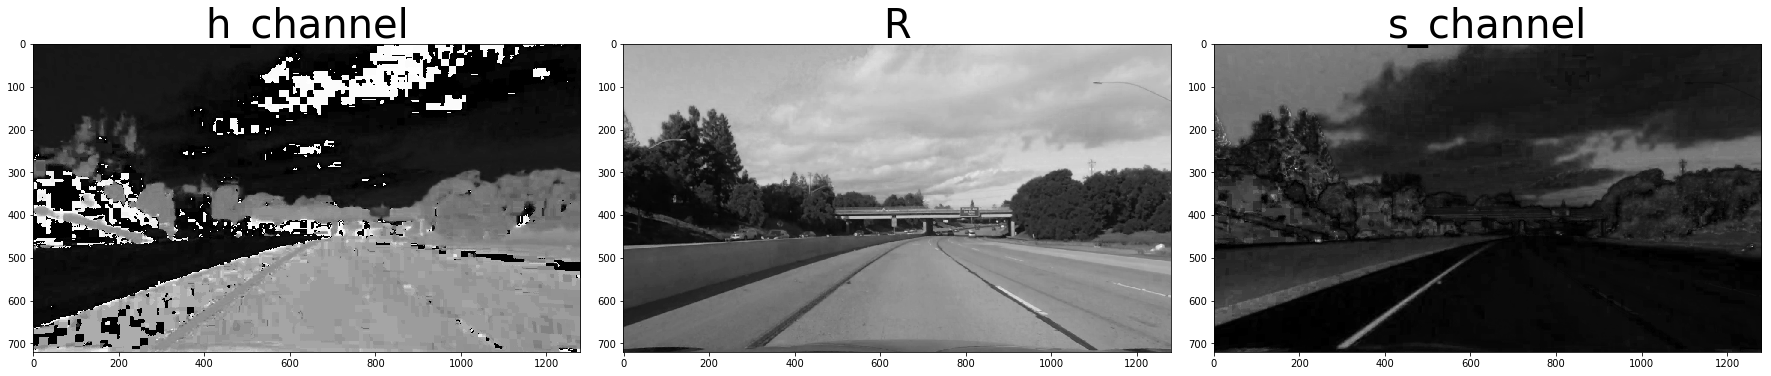

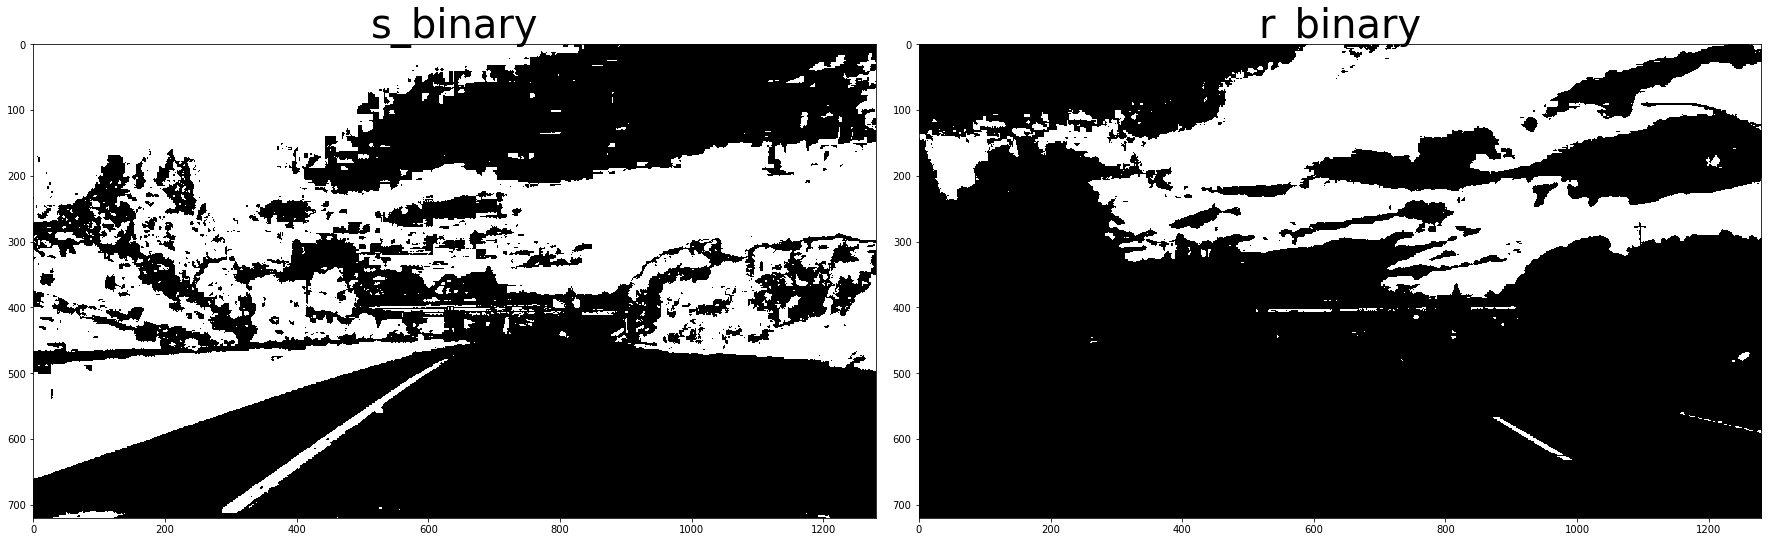

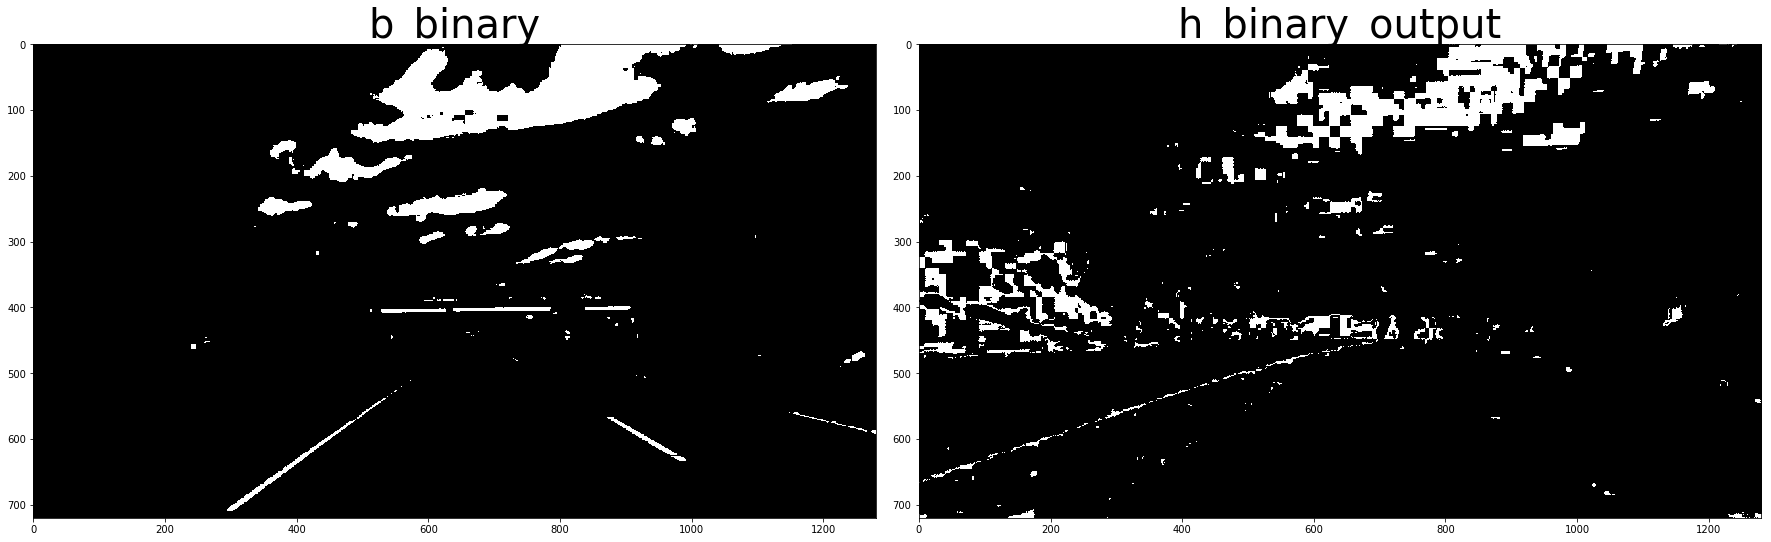

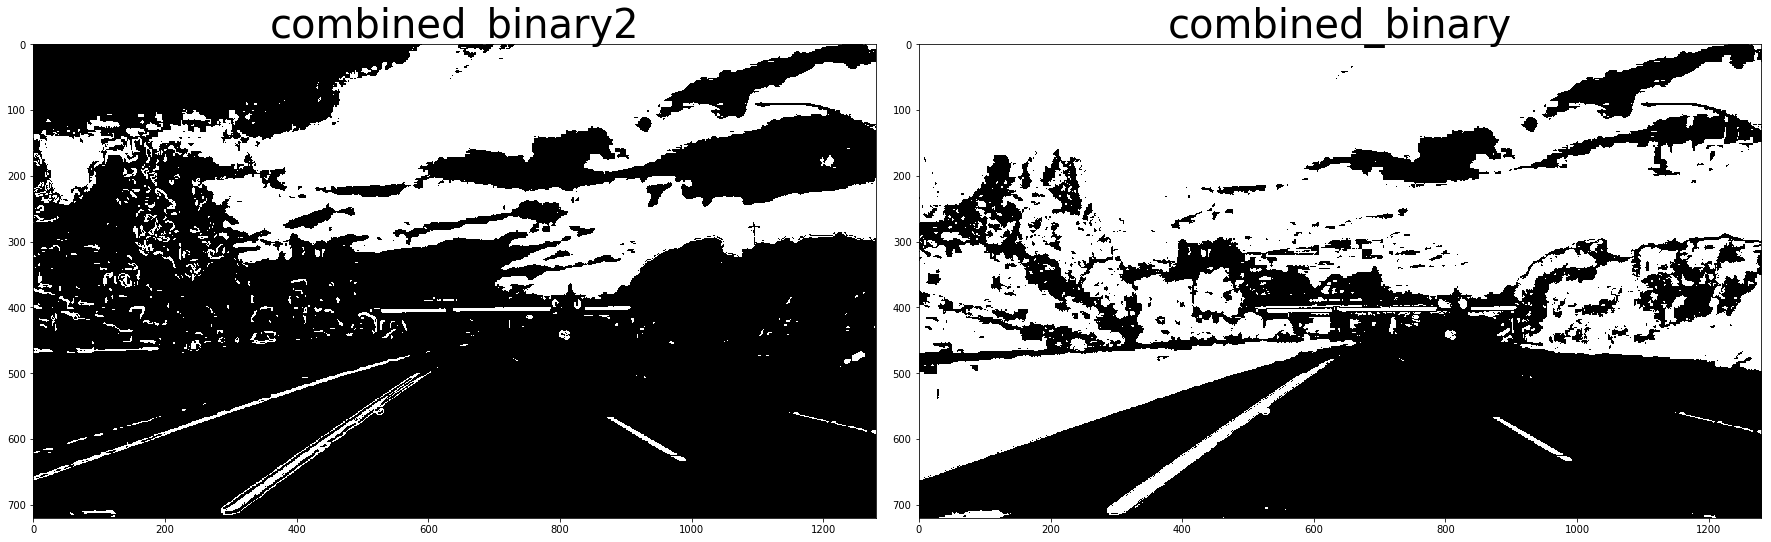

In [64]:
image = cv2.imread('test_images/challenge20.jpg')
#image = cv2.imread('error_frames/19img.jpg')
# straight_lines1
#image = cv2.imread('test_images/test1.jpg')

image = cv2.undistort(image, mtx, dist, None, mtx)

# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

h_channel = hls[:,:,0]
#l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

# dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

h_thresh = (150, 255)
h_binary_output = np.zeros_like(h_channel)
h_binary_output[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

s_thresh = (30, 140)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

# R threshold
R = image[:,:,2]
r_thresh = (182, 255)
r_binary = np.zeros_like(R)
r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

B = image[:,:,0]
b_thresh = (182, 255)
b_binary = np.zeros_like(B)
b_binary[(B > b_thresh[0]) & (B <= b_thresh[1])] = 1

# Sobel x
sx_thresh = (30, 110)
r_sx_binary = abs_sobel_thresh(R, orient='x', sobel_kernel=7, sob_thresh=sx_thresh)

# Magnitude
m_thresh = (60, 110)
s_mag_binary = mag_thresh(s_channel, sobel_kernel=11, mag_thresh=m_thresh)

dir_thresh = (0.8, 1.1)
s_dir_binary = dir_threshold(s_channel, sobel_kernel=13, thresh=dir_thresh)




# Combine the two binary thresholds
combined_binary2 = np.zeros_like(h_binary_output)
# combined_binary[(h_binary_output == 1) | (r_sx_binary == 1) | (r_binary == 1)] = 1
# combined_binary[(r_sx_binary == 1) | (r_binary == 1)] = 1
combined_binary2[(s_mag_binary == 1) | (r_binary == 1) | (b_binary == 1)] = 1


combined_binary = np.zeros_like(h_binary_output)
combined_binary[(s_mag_binary == 1) | (r_binary == 1) | (s_binary == 1) | (b_binary == 1)] = 1


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('h_channel', fontsize=40)

ax2.imshow(R, cmap='gray')
ax2.set_title('R', fontsize=40)

ax3.imshow(s_channel, cmap='gray')
ax3.set_title('s_channel', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(s_binary, cmap='gray')
ax1.set_title('s_binary', fontsize=40)

ax2.imshow(r_binary, cmap='gray')
ax2.set_title('r_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(b_binary, cmap='gray')
ax1.set_title('b_binary', fontsize=40)

ax2.imshow(h_binary_output, cmap='gray')
ax2.set_title('h_binary_output', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary2, cmap='gray')
ax1.set_title('combined_binary2', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('combined_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def show_region_of_interest(image, region):
    cv2.line(image,(region[0][0], region[0][1]),
             (region[1][0], region[1][1]),[0, 0, 255],2)
    cv2.line(image,(region[1][0], region[1][1]),
             (region[2][0], region[2][1]),[0, 0, 255],2)
    cv2.line(image,(region[2][0], region[2][1]),
             (region[3][0], region[3][1]),[0, 0, 255],2)
    cv2.line(image,(region[3][0], region[3][1]),
             (region[0][0], region[0][1]),[0, 0, 255],2)

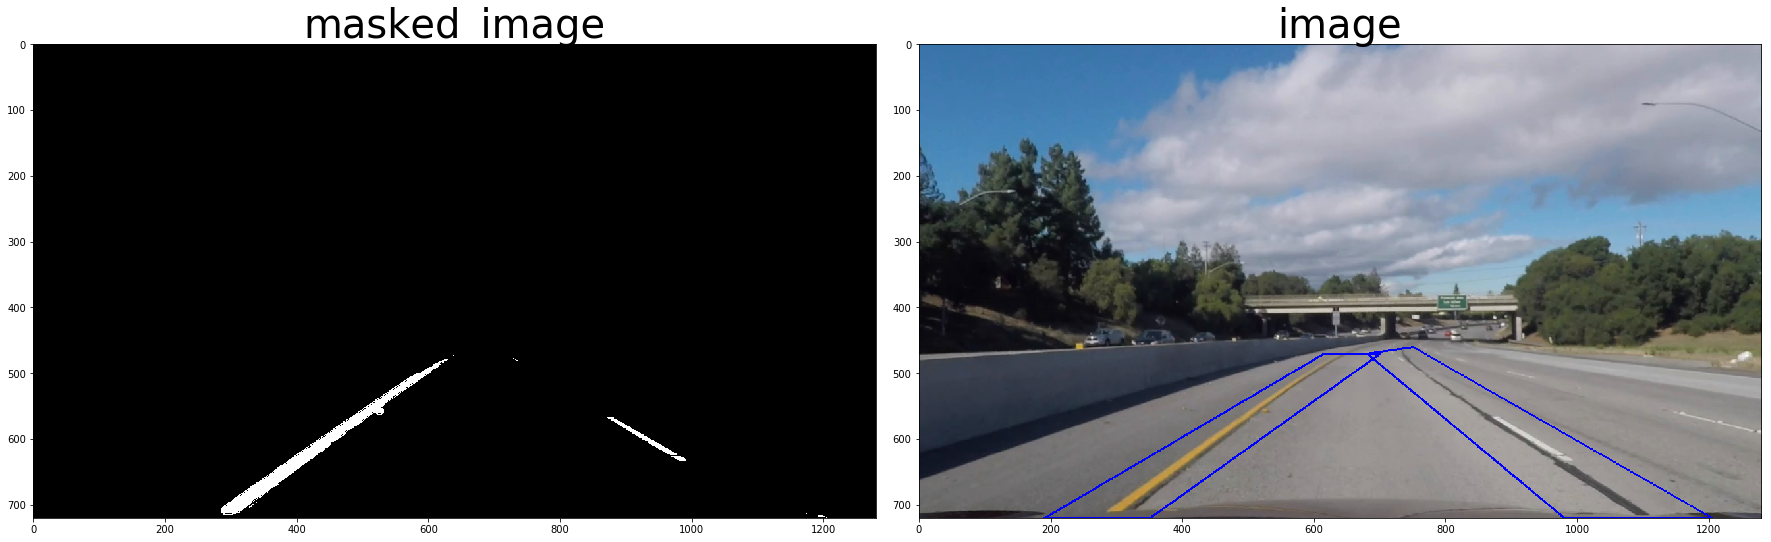

In [65]:
# getting image shape
imshape = combined_binary.shape

# print(imshape[1])
# print(imshape[0])

# setting up region in which we are interested in
#vertices = np.array([[(160,imshape[0]),(imshape[1]//2-80, imshape[0]//2+80), 
#                      (imshape[1]//2+80, imshape[0]//2+80), (imshape[1]-80,imshape[0])]], dtype=np.int32)

# vertices = np.array([[(150,imshape[0]),(imshape[1]//2-80, imshape[0]//2+80), 
#                       (imshape[1]//2+80, imshape[0]//2+80), (imshape[1]-150,imshape[0])]], dtype=np.int32)

vertices_left = np.array([[(190,imshape[0]),(imshape[1]//2-25, imshape[0]//2+110), 
                              (imshape[1]//2+60, imshape[0]//2+110), (350,imshape[0])]], dtype=np.int32)

vertices_right = np.array([[(imshape[1]-300,imshape[0]),(imshape[1]//2+40, imshape[0]//2+110), 
                          (imshape[1]//2+110, imshape[0]//2+100), (imshape[1]-75,imshape[0])]], dtype=np.int32)

masked_image = region_of_interest(combined_binary, [vertices_left, vertices_right])

show_region_of_interest(image, vertices_left[0])
show_region_of_interest(image, vertices_right[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(masked_image, cmap='gray')
ax1.set_title('masked_image', fontsize=40)

ax2.imshow(image, cmap='gray')
ax2.set_title('image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

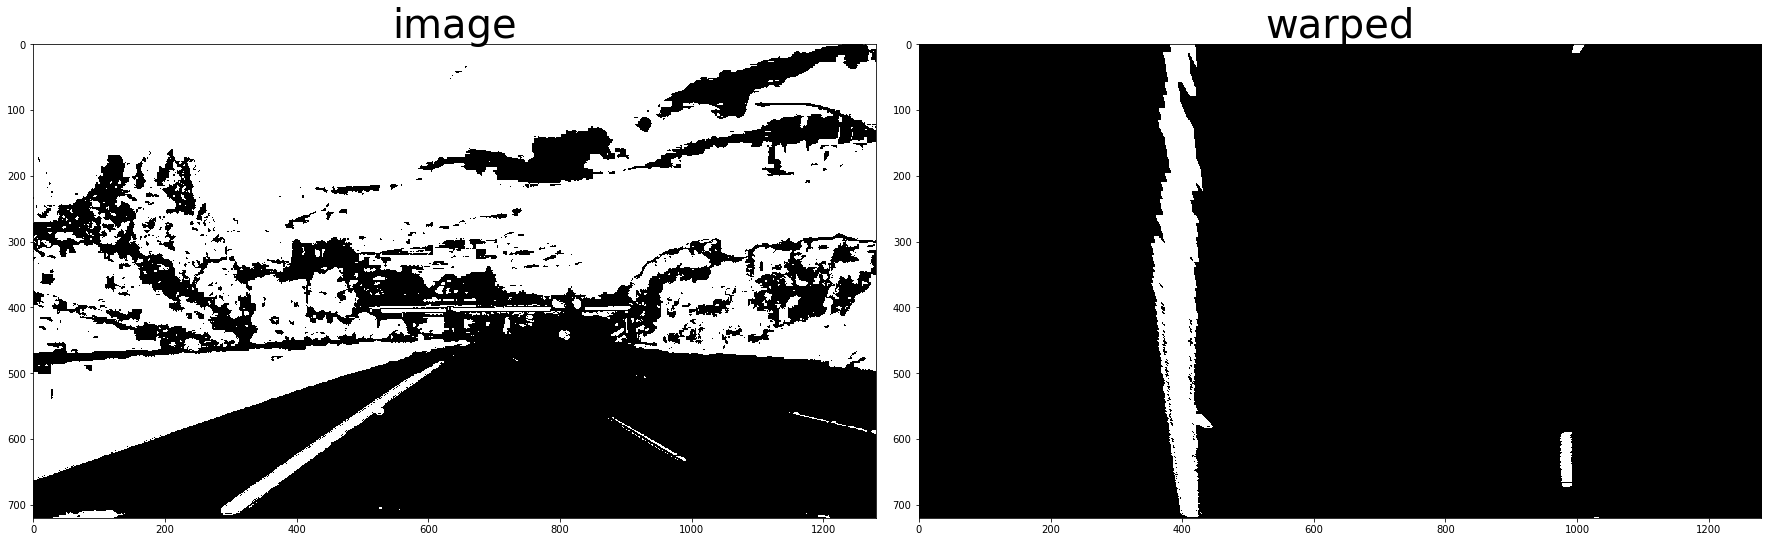

In [66]:
imshape = combined_binary.shape

offset = 100 # offset for dst points

# Grab the image shape
img_size = (combined_binary.shape[1], combined_binary.shape[0])

# print(img_size)
# For source points I'm grabbing the outer four detected corners
#src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

# setting up region in which we are interested in
#vertices = np.array([[(200,imshape[0]),(imshape[1]//2-50, imshape[0]//2+90), 
#                      (imshape[1]//2+50, imshape[0]//2+90), (imshape[1]-150,imshape[0])]], dtype=np.int32)

# vertices = np.array([[(150,img_size[1]),(img_size[0]//2-50, img_size[1]//2+90), 
#                       (img_size[0]//2+50, img_size[1]//2+90), (img_size[0]-150,img_size[1])]], dtype=np.int32)

vertices = np.array([[(190,img_size[1]),(img_size[0]//2-25, img_size[1]//2+120), 
                          (img_size[0]//2+90, img_size[1]//2+120), (img_size[0]-150,img_size[1])]], dtype=np.int32)

show_region_of_interest(combined_binary, vertices[0])



src = np.float32(vertices)


#print(src)
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result
# again, not exact, but close enough for our purposes
# dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
#                             [img_size[0]-offset, img_size[1]-offset],
#                             [offset, img_size[1]-offset]])


#dst = np.float32([[offset, img_size[1]-offset], [offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset]])
dst = np.float32([[(350,img_size[1]), (350, 0), (img_size[0]-300,0), (img_size[0]-300,img_size[1])]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(masked_image, M, img_size)

# draw_cicles(combined_binary, src[0])
# draw_cicles(warped, dst[0])

#plt.imshow(warped, cmap='gray')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding Lane Line

In [11]:
#leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

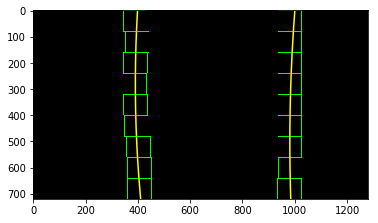

In [67]:
leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img = fit_polynomial(warped)


## Visualization ##
# Colors in the left and right lane regions
# out_img[lefty, leftx] = [255, 0, 0]
# out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

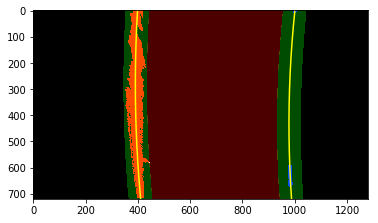

In [68]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

result = search_around_poly(warped, left_fit, right_fit)


# View your output
plt.imshow(result)

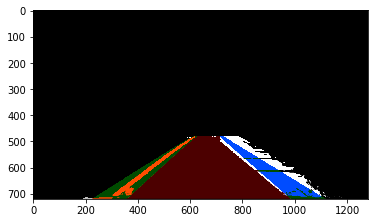

In [60]:
M_back = cv2.getPerspectiveTransform(dst, src)

warped_back = cv2.warpPerspective(result, M_back, img_size)

plt.imshow(warped_back)

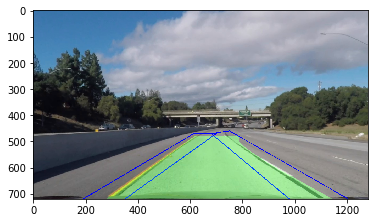

In [15]:
undist = cv2.undistort(image, mtx, dist, None, mtx)

draw_track(image, warped, M_back, left_fitx, right_fitx, ploty)

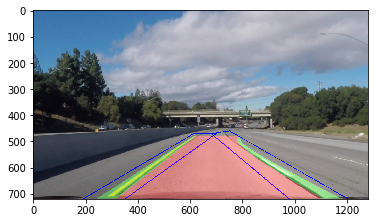

In [16]:
undist = cv2.undistort(image, mtx, dist, None, mtx)

draw_track_with_lines(image, warped, M_back, left_fitx, right_fitx, ploty)

In [17]:
line = Line()

In [18]:
print(line.current_fit)

[array([False])]


In [61]:
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 650  # meters per pixel in x dimension

# print(len(ploty))
# print(len(leftx))
# print(len(rightx))


left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

print(y_eval)

# Calculation of R_curve (radius of curvature)
# left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
# right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])

left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])  ## Implement the calculation of the left line here
right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
    2 * right_fit_cr[0])  ## Implement the calculation of the right line here


print(left_curverad)
print(right_curverad)

719.0
2038.1752576130646
5958.002769513889


In [62]:
left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)

center = img_size[0]/2

lane_center = int(right_fitx[-1] - left_fitx[-1])

offset = (center - lane_center)*xm_per_pix
print(offset)

0.7400000000000001


In [63]:
y1 = np.max(ploty)
y2 = ploty[img_size[1]//2]

left_x1 = left_fit[0] * y1 ** 2 + left_fit[1] * y1 + left_fit[2]
left_x2 = left_fit[0] * y2 ** 2 + left_fit[1] * y2 + left_fit[2]

left_slope = (left_x2 - left_x1)/(y2 - y1)
left_slope_arctan = np.arctan(left_slope)

right_x1 = right_fit[0] * y1 ** 2 + right_fit[1] * y1 + right_fit[2]
right_x2 = right_fit[0] * y2 ** 2 + right_fit[1] * y2 + right_fit[2]

right_slope = (right_x2 - right_x1)/(y2 - y1)
right_slope_arctan = np.arctan(right_slope)

print('left_slope', left_slope)
# print('left_slope_arctan', left_slope_arctan)

print('right_slope', right_slope)
# print('right_slope_arctan', right_slope_arctan)

slope_diff = abs(right_slope - left_slope)

print(slope_diff)

left_fitx_1 = left_fitx[-1]
right_fitx_1 = right_fitx[-1]

print(right_fitx_1)
print(left_fitx_1)

print(right_fitx_1 - left_fitx_1)

print(480 < right_fitx_1 - left_fitx_1 < 700)

left_slope 0.08708167086674469
right_slope 0.017239290314746147
0.06984238055199854
928.129810402982
417.1336645907813
510.9961458122007
True
